In [90]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
import math

In [56]:
os.listdir('data')

['application_test.csv',
 'application_train.csv',
 'bureau.csv',
 'bureau_balance.csv',
 'credit_card_balance.csv',
 'HomeCredit_columns_description.csv',
 'installments_payments.csv',
 'POS_CASH_balance.csv',
 'previous_application.csv',
 'sample_submission.csv']

## Load the data sets

In [57]:
app_train = pd.read_csv('data/application_train.csv')
app_test = pd.read_csv('data/application_test.csv')
bureau = pd.read_csv('data/bureau.csv')
bureau_balance = pd.read_csv('data/bureau_balance.csv')
cc_balance = pd.read_csv('data/credit_card_balance.csv')
installments_payments = pd.read_csv('data/installments_payments.csv')
pos_balance = pd.read_csv('data/POS_CASH_balance.csv')
previous_application = pd.read_csv('data/previous_application.csv')

Let's focus on the main application data for now and gain further insights:

## Exploratory Data Analysis

In [58]:
app_train.info()
app_train.dtypes.value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


float64    65
int64      41
object     16
dtype: int64

In [59]:
# Examine missing values:

def find_missing_values(df):
    missing_values_count = df.isnull().sum().sort_values(ascending=False)
    missing_values_count = missing_values_count[missing_values_count.iloc[:] != 0]
    missing_values_percent = ((missing_values_count/len(df))*100).round(1)
    missing_values = pd.concat([missing_values_count,missing_values_percent],axis=1,keys=['Count','Percent'])
    print('There are {} columns missing values'.format(missing_values_count.shape[0]))
    return(missing_values)

In [60]:
find_missing_values(app_train).head(20)

There are 67 columns missing values


,Count,Percent
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


Later we should come up with a way to immute these values

Lets look at the categorical features

In [61]:
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

### Examining features
Let's take a closer look at some features that might help us understand the trend. We have 122 features in the main data set. Investigating all of them won't be an efficient process of gaining insights. Calculating their correlation with the target variable will help us get started with finding feature importance:

* Loan Information - AMT_CREDIT, AMT_ANNUITY,
* Client's Age - DAYS_BIRTH
* Clent's Income - AMT_INCOME_TOTAL, NAME_INCOME_TYPE
* Client's Occupation - DAYS_EMPLOYED, OCCUPATION_TYPE, ORGANIZATION_TYPE
* Client's Social Info - FLAG_OWN_CAR, FLAG_OWN_REALTY, NAME_HOUSING_TYPE, REGION_POPULATION_RELATIVE, OWN_CAR_AGE, REGION_RATING_CLIENT, REGION_RATING_CLIENT_W_CITY, 
* Cleint's Family Information - CNT_CHILDREN, NAME_FAMILY_STATUS, CNT_FAM_MEMBERS


In [79]:
# Lets set some visualization parameters:
plt.style.use('fivethirtyeight')

Text(0.5,1,'Target label distribution')

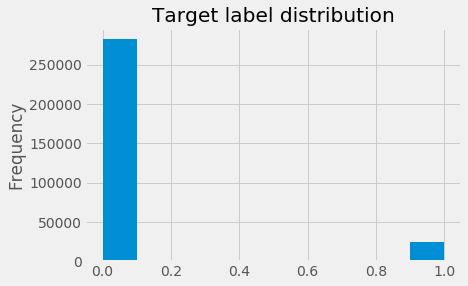

In [80]:
# Examining target label distribution:
app_train['TARGET'].plot.hist()
plt.title('Target label distribution')

We seem to have a class imbalance problem. We need to weight the classes when we use a model.

#### Looking at categorical features:

Let's look at some categorical features before we encode them:

In [187]:
def plot_bars(data,features,target_label):
    width = 0.5
    rows = len(features)
    for i,feature in enumerate(features):
        defaulters = data.loc[data[target_label] == 1, feature].value_counts()
        repaid = data.loc[data[target_label]==0,feature].value_counts()
        datasets = [repaid,defaulters]
        for k,dataset in enumerate(datasets):
            for clas in dataset.index:
                if clas not in datasets[~k]:
                    datasets[~k][clas] = 0
        ind1 = np.arange(len(repaid.values))*1.5
        ind2 = ind1 + 0.5
        plt.subplot(rows,1,i+1)
        plt.bar(ind1, repaid.values,width,color='blue',alpha=0.7)
        plt.bar(ind2, defaulters.values,width,color='yellow',alpha=0.9)
        plt.xticks(ind1+0.25,list(repaid.index),rotation=45)
        plt.title(f'Loan Repayment in terms of {feature}')
        plt.legend(labels=['Repayed','Defaulted'])        

#### Occupation type:

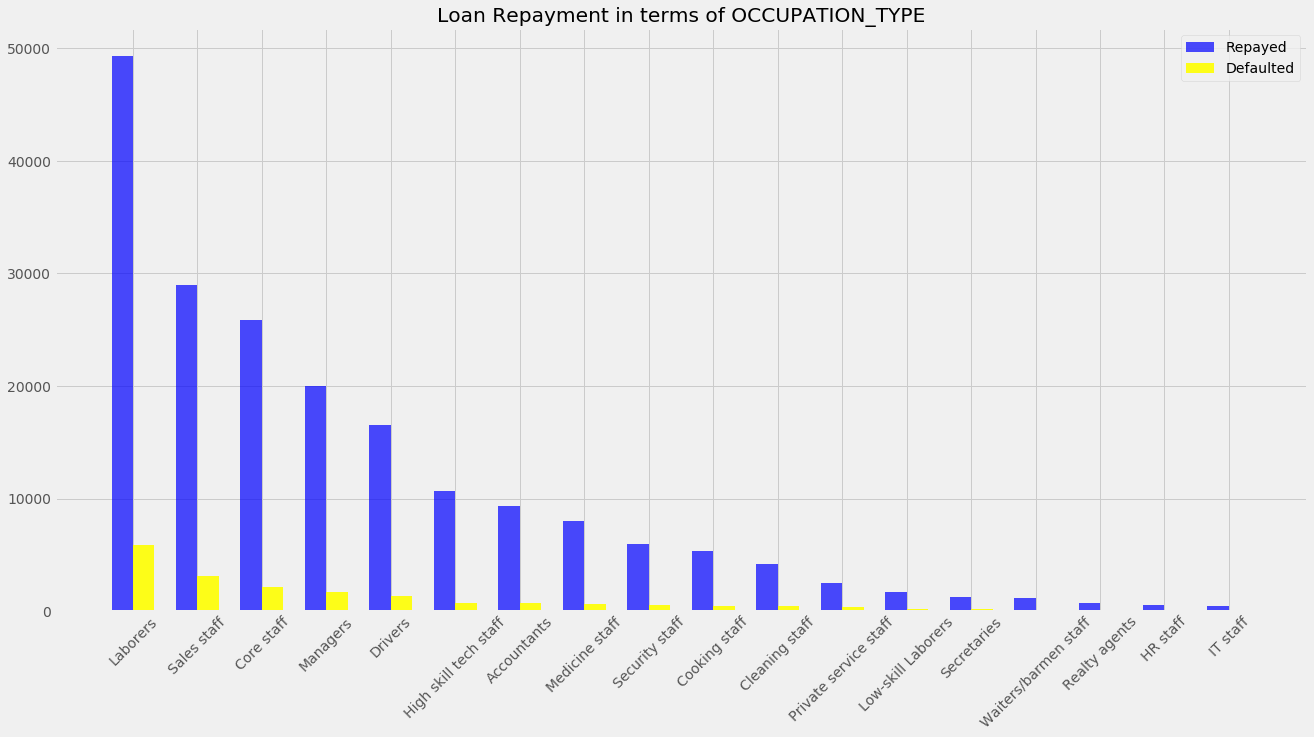

In [188]:
fig = plt.figure(figsize=(20,10))
plot_bars(app_train,['OCCUPATION_TYPE'],'TARGET')

It seems that laborers top the chart at taking out loans. Although from the bar chart it may appear that they are the ones having the most difficulty repaying the loans, this could be mainly because they are the highest borrowers. 

####  Education:

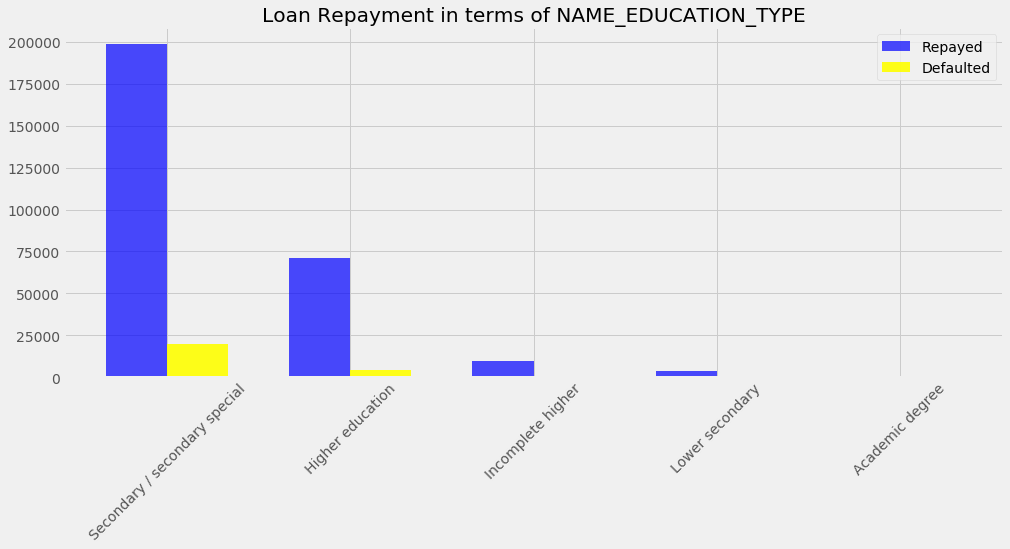

In [189]:
fig = plt.figure(figsize=(15,6))
plot_bars(app_train,['NAME_EDUCATION_TYPE'],'TARGET')

Client's with Secondary/secondary special education are amognst the highest borrowers. While clients with other education levels besides higher education seems to borrow less. We could drop these features later to improve model performance.

#### Income type 

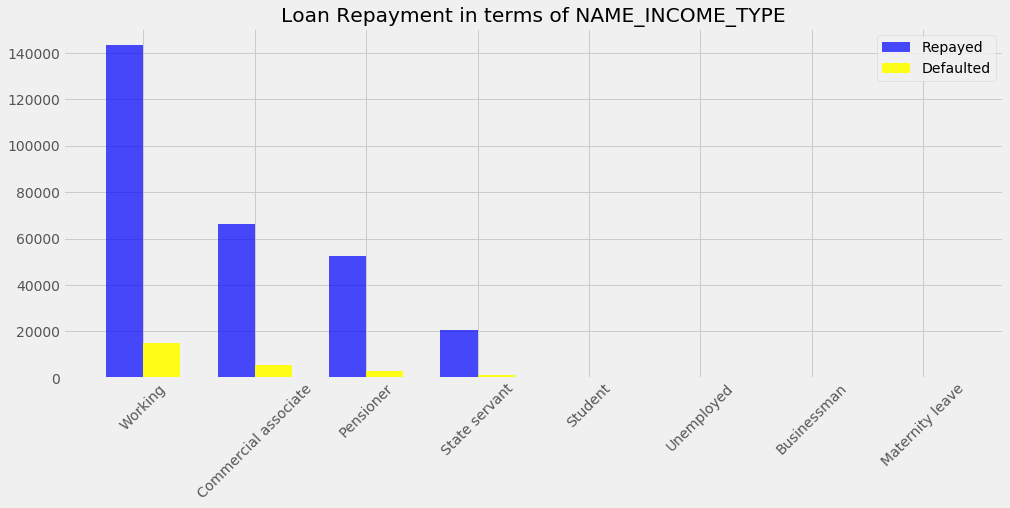

In [191]:
fig = plt.figure(figsize=(15,6))
plot_bars(app_train,['NAME_INCOME_TYPE'],'TARGET')

We moslty have working people borrowing loans. A couple of categories of income type such as student and unemployed seem to have insignificant amount of data. Later when these features are encoded, we could remove them if they do not add much value.

#### Correlations:

In [64]:
cors = app_train.corr()['TARGET'].sort_values()

In [65]:
print('Most Postive correlations:\n',cors.tail(15).sort_values(ascending=False))
print('\nMost Negative correlations:\n',cors.head(15))

Most Postive correlations:
 TARGET                         1.000000
DAYS_BIRTH                     0.078239
REGION_RATING_CLIENT_W_CITY    0.060893
REGION_RATING_CLIENT           0.058899
DAYS_LAST_PHONE_CHANGE         0.055218
DAYS_ID_PUBLISH                0.051457
REG_CITY_NOT_WORK_CITY         0.050994
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_DOCUMENT_3                0.044346
DAYS_REGISTRATION              0.041975
OWN_CAR_AGE                    0.037612
LIVE_CITY_NOT_WORK_CITY        0.032518
DEF_30_CNT_SOCIAL_CIRCLE       0.032248
DEF_60_CNT_SOCIAL_CIRCLE       0.031276
Name: TARGET, dtype: float64

Most Negative correlations:
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED                -0.044932
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645
R

* **Positive correlations**: this tells us as the value of the feature increases, the client is more likely to *not* repay the loan on time. 

* **Negative correlations**: as the value of the feature increases, the client it more likely to repay the loan. 

Let's look at some of the features on this list. 

#### Quick and dirty overview of highly correlated feature's distributions 

In [122]:
def plot_distributions(dataframe,features,target_label):
    """create KDE plots for features
    parameters:
    ------------
    dataframe: pandas dataframe containing the features
    featrues: list of strings containing feature names
    target_label: target label string
    """
    rows = math.ceil(len(features)/3)
    for i,feature in enumerate(features):
        plt.subplot(rows,3,i+1)
        sns.kdeplot(dataframe.loc[dataframe[target_label] ==0,feature],label='Repayed')
        sns.kdeplot(dataframe.loc[dataframe[target_label]==1,feature],label='Defaulted')
        plt.title(f'Distribution of {feature}')
        

In [125]:
nc_features = list(cors.index[0:9]) # get nine most negatively correlated features
pc_features = list(cors.index[-10:-1]) # get nine most positively correlated features

C:\Users\amah\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
C:\Users\amah\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


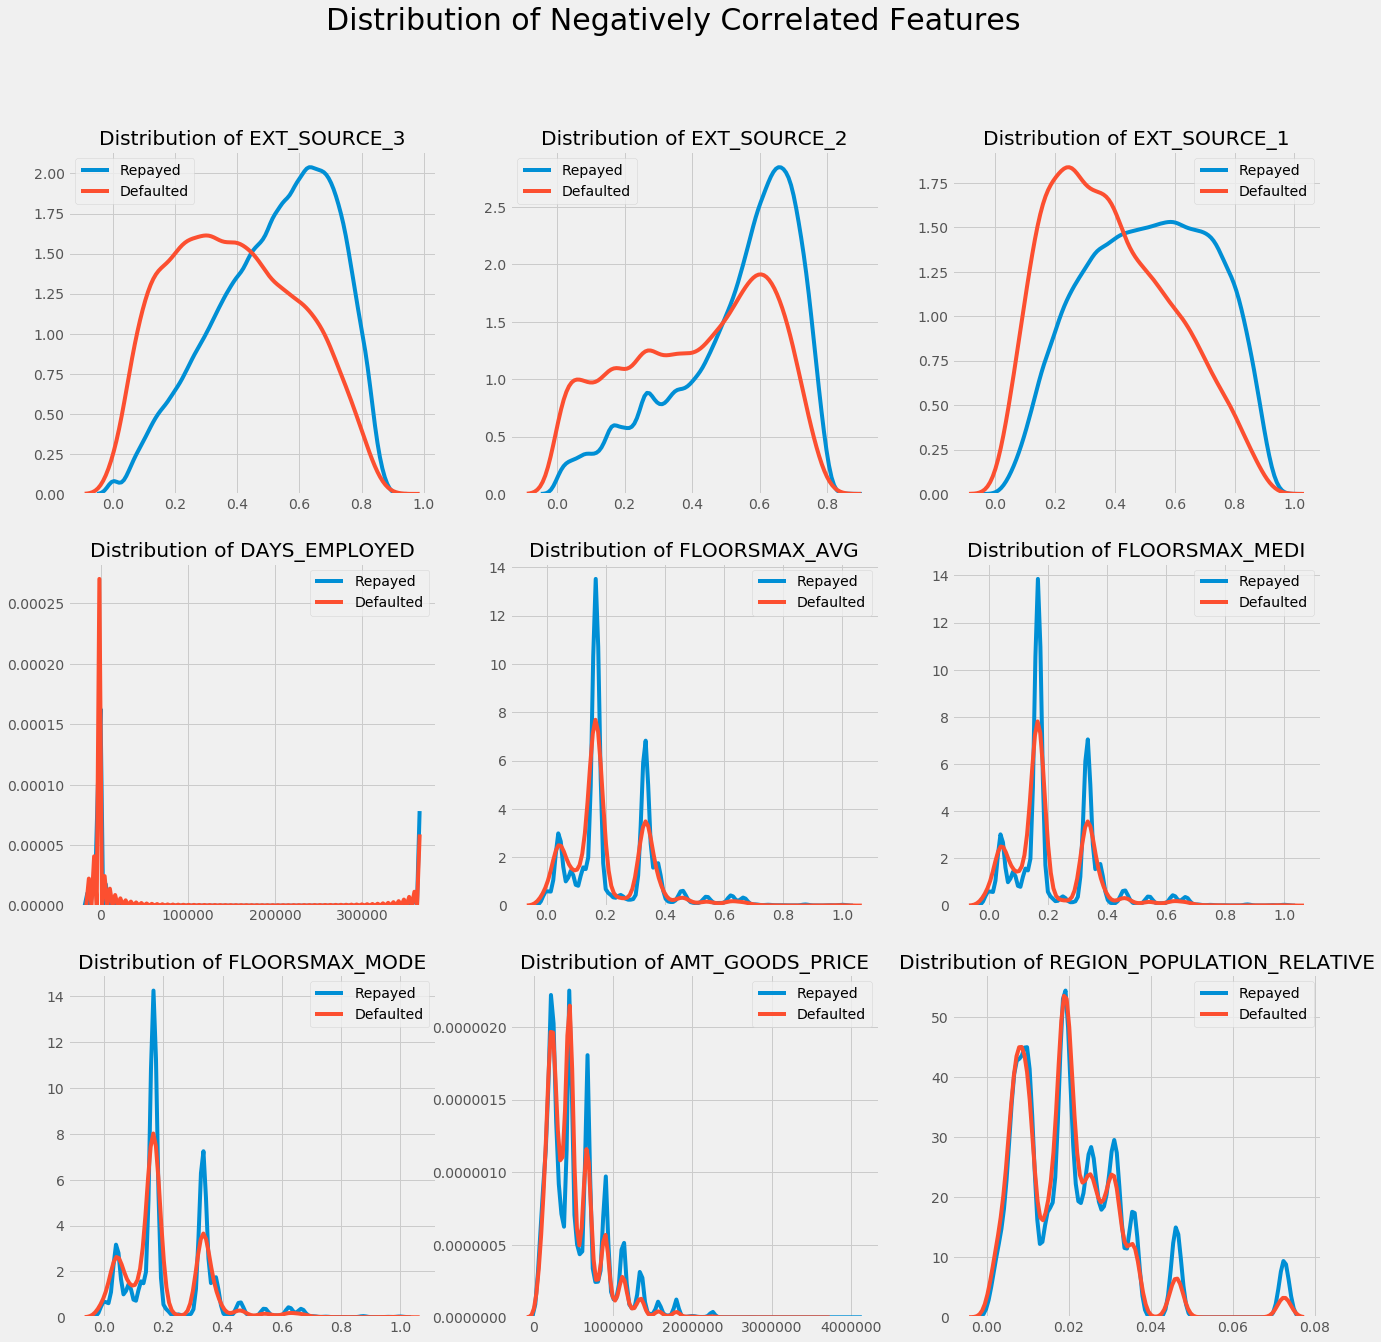

In [127]:
fig = plt.figure(figsize=(20,20))
plt.suptitle('Distribution of Negatively Correlated Features',fontsize=30)
plot_distributions(app_train,nc_features,'TARGET')

**Observations:**
* We can see a clear trend with the external source 3 and 1 features. Clients with higher score in these tend to repay their loans of time
* Days employed seem to have some anomalies which is skewing the distributions. Lets investigate and remove them


#### Age (DAYS_BIRTH):

It might strike odd at first that as the client gets older they are less likely to repay on time.

145214   -16706
100564   -22301
16917    -16922
238825   -11880
Name: DAYS_BIRTH, dtype: int64

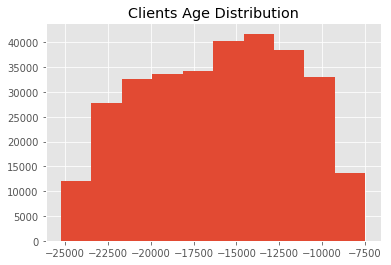

In [15]:
app_train['DAYS_BIRTH'].hist()
plt.title('Clients Age Distribution')
app_train['DAYS_BIRTH'].sample(4)

Well, it seems to be because the numbers are in negative. Which means that the correlation is actually opposite. Let's confirm this.

In [66]:
ages = abs(app_train['DAYS_BIRTH'])
ages.corr(app_train['TARGET'])

-0.07823930830982712

This confirms that indeed, as the client gets older, they are more likely to repay the loans.

In [67]:
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])

## Data Preprocessing

### Encoding categorical features:

In [22]:
# Label encoding for features with 2 categories, one-hot encoding for features with more than two categories

label_encoder = preprocessing.LabelEncoder()
lecount = 0
for col in app_train:
    if app_train[col].dtype == 'object':
        if len(list(app_train[col].unique())) <= 2:
            label_encoder.fit(app_train[col])

            app_train[col] = label_encoder.transform(app_train[col])
            app_test[col] = label_encoder.transform(app_test[col])

            lecount += 1

In [23]:
# One-hot encoding categorical features
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

In [24]:
# Aligning training and testing data

targets = app_train['TARGET']

app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

app_train['TARGET'] = targets

print(app_train.shape)
print(app_test.shape)

(307511, 240)
(48744, 239)


### Imputing Missing values & Scaling: 

In [25]:
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import MinMaxScaler

In [42]:
# Test data

train = app_train.copy()
train = train.drop('TARGET',axis =1)

test = app_test.copy()

imputer = Imputer(strategy='most_frequent')
imputer.fit(train)

# Impute training and testing data

train = imputer.transform(train)
test = imputer.transform(test)

# Scaling:

scaler = MinMaxScaler()
scaler.fit(train)

train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (307511, 239)
Testing data shape:  (48744, 239)


## Baseline modelling 

#### Splitting data for CV 

In [43]:
from sklearn.model_selection import train_test_split

In [44]:
ylabels = app_train['TARGET']

In [45]:
x_train, x_test, y_train, y_test = train_test_split(
                          train, ylabels, test_size=0.25, random_state=42)

In [46]:
print('Training set size:{}'.format(x_train.shape))
print('Testing set size:{}'.format(x_test.shape))

Training set size:(230633, 239)
Testing set size:(76878, 239)


#### Decision Tree

In [47]:
from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier()
classifier.fit(x_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [48]:
dt_predictions = classifier.predict_proba(x_test)[:,1]

In [49]:
from sklearn.metrics import roc_auc_score

In [50]:
dt_score = roc_auc_score(y_test,dt_predictions)
print('Vanilla Decision Tree score: ',dt_score)

Vanilla Decision Tree score:  0.5374859487859394


#### Logistic Regression

In [51]:
from sklearn.linear_model import LogisticRegression

In [52]:
lr_classifier = LogisticRegression(C=0.0001)

In [53]:
lr_classifier.fit(x_train,y_train)
lr_predictions = lr_classifier.predict_proba(x_test)[:,1]

In [54]:
lr_score = roc_auc_score(y_test,lr_predictions)
print('Logistic Regression score: ',lr_score)

Logistic Regression score:  0.6839361381505498
